# Fitting
In this notebook, I'll show how to use `Korg.Fit.fit_spectrum` to fit one of the spectra from [Griffith et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv221001821G). You will probably find it helpful to look at the [documentation for this function](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.Fit.fit_spectrum) as well. For fitting equivalent widths (rather than spectra directly) see [the documentation for `Korg.Fit.ews_to_abundances`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.Fit.ews_to_abundances).

This notebook is intended to demonstrate the usages of Korg's fitting functionality, not an ironclad spectral analysis.

A massive thanks to Emily Griffith for helping to translate this notebook into Python.

In [1]:
from matplotlib import pyplot as plt
from juliacall import Main as jl
import time
import random
import numpy as np
import pandas as pd

jl.seval("using Korg")
Korg = jl.Korg

## Read in the linelist, window list, and spectrum

For this example, we'll use the same linelist and windows as Griffith et al. 2022, which means reading the CSV files they are stored in and getting the data into the format expected by Korg.

In [2]:
# read and parse the linelist used by Griffith et al. 2022
linetable = pd.read_csv("lines.csv");

In [3]:
linelist = jl.broadcast(Korg.Line, 
                        jl.broadcast(Korg.air_to_vacuum,linetable.wave_A),
                        linetable.loggf,
                        jl.broadcast(Korg.Species,linetable.element),
                        linetable.lower_state_eV,
                        linetable.rad,
                        linetable.stark,
                        linetable.waals)


In [4]:
# read windows into dictionary that maps atomic number -> window list
windowtable = pd.read_csv("windows.tsv", delimiter='\t');

In [5]:
windowtable

,wave_peak,wave_base,wave_top,species
0,424.6822,424.6522,424.7122,Sc 2
1,432.0732,432.0432,432.1032,Sc 2
2,432.0950,432.0650,432.1250,Ti 2
3,433.1642,433.1342,433.1942,Ni 1
4,433.7046,433.6746,433.7346,Fe 1
...,...,...,...,...
395,625.2555,625.2255,625.2855,Fe 1
396,625.8102,625.7802,625.8402,Ti 1
397,625.8707,625.8407,625.9007,Ti 1
398,626.5132,626.4832,626.5432,Fe 1


In [6]:
windows = {}
for i, row in windowtable.iterrows():
    # atomic number
    Z = Korg.get_atoms(Korg.Species(row.species))[0]
    # get the windows for this element so far 
    wins = windows.get(Z, [])
    # add the new window
    wins.append((Korg.air_to_vacuum(row.wave_base * 10), Korg.air_to_vacuum(row.wave_top * 10)))
    # update the dictionary
    windows[Z] = wins

In [7]:
# parse the observed spectrum
spec = pd.read_csv("2MASS_J03443498+0553014.csv", delimiter="\t")

# juliacall deals better with numpy arrays than pandas series, so we will work with those
flux = np.array(spec.flux)
err = np.array(spec.err)
waveobs = np.array(jl.broadcast(Korg.air_to_vacuum, spec.waveobs * 10))

# Get stellar params with just Fe lines
First, we'll use the Fe windows from `windows.tsv` to fit for the stellar parameters. You may notice that the first time you run this, the `@time` macro reports a high fraction of time spent compiling.  This happens only once per session. 

In [8]:
# provide an initial guess for each parameter we want to fit
# (This is how to construct a NamedTuple in Julia, by the way.)
initial_guess = dict(Teff=5400, logg=3.8, m_H=-1.1, vmic=1.0)
winds = windows[26] # use Fe windows

# In this example, we'll pass the spectral resolution R and let Korg take care of the line spread function automatically
# Below, I'll show how to speed things up by calculating it ahead of time.
fit_result = Korg.Fit.fit_spectrum(waveobs, flux, err, linelist, initial_guess, windows=winds, R=50_000)
;

Constructing LSF matrix  31%|███████�▌                   |  ETA: 0:00:19[K

''

Constructing LSF matrix 100%|████████████████████████████| Time: 0:00:16SF matrix  86%|████████████████████████▏   |  ETA: 0:00:03


`fit_result` is an object containing several bits of info, most importantly the best-fit parameters

In [9]:
fit_result.best_fit_params

Dict{String, Float64} with 4 entries:
  "Teff" => 5261.03
  "logg" => 3.68391
  "m_H"  => -1.33159
  "vmic" => 0.834441

It also contains the trace, which we can plot like so

''

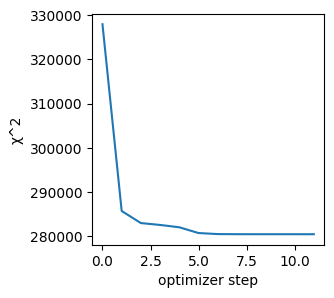

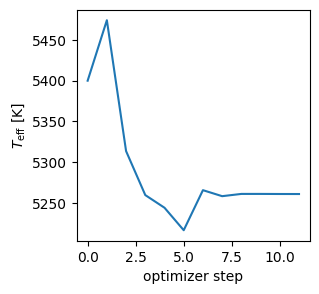

In [10]:
plt.figure(figsize=(3,3))
plt.plot([t["chi2"] for t in fit_result.trace])
plt.ylabel("χ^2")
plt.xlabel("optimizer step")

plt.figure(figsize=(3,3))
plt.plot([t["Teff"] for t in fit_result.trace])
plt.ylabel("$T_\mathrm{eff}$ [K]")
plt.xlabel("optimizer step")
;

The `fit_result` object also contains the best-fit spectrum, which we can plot in comparision to the oberved one.  Rerun the cell below to plot data for different iron lines.

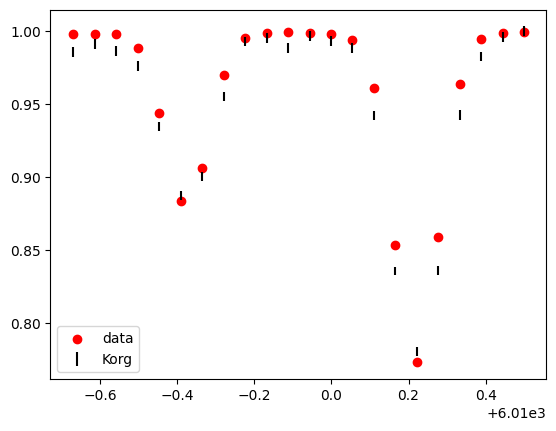

In [11]:
# get the observed spectrum only at the wavelengths within a fitting window
obsmask = np.array(fit_result.obs_wl_mask)
obs_wls = waveobs[obsmask]
obs_flux = flux[obsmask]
obs_err = err[obsmask]

w = random.choice(winds) # choose a window around a random Fe line

# create a bitmask to plot the window plus 1 Å on each side for context
mask = np.array((w[0]-1 < obs_wls) & (obs_wls < w[1]+1))

plt.scatter(obs_wls[mask], np.array(fit_result.best_fit_flux)[mask], c="r", label="data")
plt.errorbar(obs_wls[mask], obs_flux[mask], yerr=obs_err[mask], ls="", c="k", label="Korg")
plt.legend()

# Fit individual abundances
In this example, we'll calculate a matrix to apply the line-spead function ahead of time, saving the step of doing it for each fit.

In [12]:
# construct sparse matrix which simultaneously applies the LSF and downsamples to wavelengths of the observation
synthesis_wls = jl.range(start = 4200, stop=6350, step=0.01)
LSF_matrix = Korg.compute_LSF_matrix(synthesis_wls, waveobs, 50_000)
;

Constructing LSF matrix  36%|██████████                  |  ETA: 0:00:17

''

Constructing LSF matrix 100%|████████████████████████████| Time: 0:00:16KKting LSF matrix  73%|████████████████████▍       |  ETA: 0:00:06


Let's use the stellar parameters from Griffith, rather than the ones from the analysis above. Comparing the abundances you get using each is left as an excercise to the reader.

In [13]:
griffith_params = dict(Teff = 5456, logg = 3.86, m_H = -1.22, vsini = 2.4, vmic=1.23)
print(dict(fit_result.best_fit_params))
print(griffith_params)

{'Teff': 5261.031077003572, 'logg': 3.683914136304672, 'm_H': -1.3315932035005438, 'vmic': 0.8344413978568768}
{'Teff': 5456, 'logg': 3.86, 'm_H': -1.22, 'vsini': 2.4, 'vmic': 1.23}


# find individual abundances

In [14]:
def best_fit_abundance(element):
    print("fitting %s..." % (element))
        
    # use a Dict to store initial guesses at each param instead of a NamedTuple
    params = {element: griffith_params["m_H"]}

    # "params" specifies the initial guesses at the params to fit (in this case a single elemental abundance).
    # griffith_params specifies values which should be fixed (in this case the stellar parameters).
    # We also pass in the precomputed LSF matrix and corresponding synthesis wavelengths.
    t = time.process_time()
    fit_result = Korg.Fit.fit_spectrum(waveobs, flux, err, linelist, params, griffith_params,
                                       windows=windows[Korg.atomic_numbers[element]],
                                       synthesis_wls=synthesis_wls, LSF_matrix=LSF_matrix)
    print(time.process_time() - t, " seconds")

    # return the best-fit abundance
    return fit_result.best_fit_params[element]


In [15]:
elements = ["Na", "Mg", "Si", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni"]
Korg_abunds = [best_fit_abundance(e) for e in elements]

fitting Na...
24.444057000000015  seconds
fitting Mg...
1.8595980000000054  seconds
fitting Si...
2.3797750000000235  seconds
fitting Ca...
2.558094000000011  seconds
fitting Sc...
2.4934800000000052  seconds
fitting Ti...
3.607448000000005  seconds
fitting V...
2.4483060000000023  seconds
fitting Cr...
2.283128000000005  seconds
fitting Mn...
3.370252000000022  seconds
fitting Fe...
6.261819000000003  seconds
fitting Co...
2.1587669999999832  seconds
fitting Ni...
2.938112999999987  seconds


Let's plot these in comparison to the Griffith et al. 2022 abundaces.

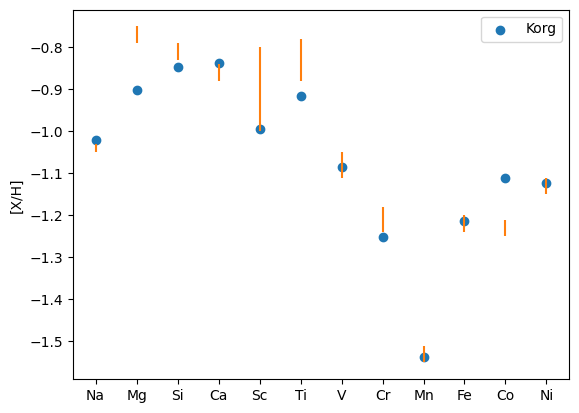

In [16]:
# The are the [X/H] values from the paper (and the errors inferred from Monte-Carlo)
griffith_X_H = [-1.04, -0.77, -0.81, -0.86, -0.9, -0.83, -1.08, -1.21, -1.53, -1.22, -1.23, -1.13]
griffith_X_H_err = [0.01, 0.02, 0.02, 0.02, 0.1, 0.05, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02]

plt.scatter(range(len(elements)), Korg_abunds, label="Korg")
plt.errorbar(range(len(elements)), griffith_X_H, yerr=griffith_X_H_err, ls="", c="C1")
plt.xticks(range(len(elements)), elements)
plt.ylabel("[X/H]")
plt.legend()
